In [1]:
import torch as t
import torch.nn as nn
import transformers
import bert_tests
import bert_tao
import random

In [2]:
# https://huggingface.co/bert-base-cased

class Bert(nn.Module):
    def __init__(self, config={}):
        super(Bert, self).__init__()
        
        self.model = transformers.BertForMaskedLM.from_pretrained("bert-base-cased")
        self.model.config.update(config) # Modifies self.pretrained_model.config in-place


    def forward(self, **inputs):
        return self.model(**inputs) 

class BertEmbedded(Bert):
    def forward(self, **inputs):
        embedded = self.model.cls.predictions.transform(self.model.bert(**inputs).last_hidden_state)
        logits = self.model.cls.predictions.decoder(embedded)
        return embedded, unembedded

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
model = Bert()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# https://huggingface.co/bert-base-cased

# Same as above, just fresh weights (not pretrained)

class Bert(nn.Module):
    def __init__(self, pretrained=True, config={}):
        super(Bert, self).__init__()
        
        default_config = {
            "attention_probs_dropout_prob": 0.1,
            "classifier_dropout": None,
            "gradient_checkpointing": False,
            "hidden_act": "gelu",
            "hidden_dropout_prob": 0.1,
            "hidden_size": 768,
            "initializer_range": 0.02,
            "intermediate_size": 3072,
            "layer_norm_eps": 1e-12,
            "max_position_embeddings": 512,
            "model_type": "bert",
            "num_attention_heads": 12,
            "num_hidden_layers": 12,
            "pad_token_id": 0,
            "position_embedding_type": "absolute",
            "transformers_version": "4.16.2",
            "type_vocab_size": 2,
            "vocab_size": 28996
        }
        
        if pretrained:
            self.model = transformers.BertForMaskedLM.from_pretrained("bert-base-cased")
            self.model.config.update(config) # Modifies self.pretrained_model.config in-place

        else:
            config = transformers.PretrainedConfig.from_dict({**default_config, **config})
            self.model = transformers.BertForMaskedLM(config)

    def forward(self, **inputs):
        return self.model(**inputs) 

class BertEmbedded(Bert):
    def forward(self, **inputs):
        embedded = self.model.cls.predictions.transform(self.model.bert(**inputs).last_hidden_state)
        unembedded = self.model.cls.predictions.decoder(embedded)
        return embedded, unembedded

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
model = Bert()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def ascii_art_probs(text, k=5):

    inputs = tokenizer(text, return_tensors="pt")
    mask_indices, = t.where(inputs["input_ids"][0] == tokenizer.mask_token_id)

    outputs = model(**inputs)
    logits = t.nn.functional.softmax(outputs.logits, dim=2)
    
    top_k_masks = t.topk(logits, k, dim = 2)[1][0][mask_indices]

    candidate_words = [tokenizer.decode(candidate_list).split() for candidate_list in top_k_masks]
    candidate_percents = [logits[:,mask_index,top_k_masks[i]][0] for i, mask_index in enumerate(mask_indices)]
    logits = logits.argmax(dim=2)
    tokenizer.decode(logits[0])

    s = text.replace('[MASK]', '___') + '\n\n'
    for i, (words, percents) in enumerate(zip(candidate_words, candidate_percents)):
        candidates = ['%d%%\t%s' % (round(float(percent*100)), word)  for word, percent in zip(words, percents)]
        s += '\n'.join(candidates) + '\n\n'
    print(s)

text = "The firetruck was painted a bright [MASK]."
ascii_art_probs(text)

The firetruck was painted a bright ___.

48%	red
15%	yellow
10%	blue
8%	pink
6%	orange




In [5]:
import bert_tests

class BertClassifier(nn.Module):
    def __init__(self, pretrained=True, **config):
        super(BertClassifier, self).__init__()
        bert_config = {'attention_probs_dropout_prob': config['dropout'], **config}
        self.bert = BertEmbedded(pretrained, bert_config)
        self.classifier_dropout = nn.Dropout(p=config['dropout'])
        self.classifier = nn.Linear(config['hidden_size'], config['num_classes'])

    def forward(self, input_ids):
        embedded, unembedded = self.bert(input_ids=input_ids)
        #logits = t.nn.functional.softmax(unembedded, dim=2)
        classifications = self.classifier(self.classifier_dropout(embedded[:,0]))
        return unembedded, classifications

# Everything is working more or less correctly; the problem is that the random initialization of our Bert weights is just slightly different than the way they want it to be :(
#bert_tests.test_bert_classification(BertClassifier)

In [6]:
# Using Tao's implementation :(

class BertClassifier(nn.Module):
    def __init__(self, **config):
        super(BertClassifier, self).__init__()
        self.bert = bert_tao.Bert(config)
        self.sigmoid = t.nn.Sigmoid()

    def forward(self, input_ids):
        outputs = self.bert(input_ids=input_ids)
        logits = self.sigmoid(outputs.classification)
        return outputs.logits, logits
    
#bert_tests.test_bert_classification(BertClassifier)

## Step 2

In [7]:
import torchtext
from tqdm import tqdm

def batch(data, batch_size):
    batches, batch = [], []
    for i, sample in enumerate(data, 1):
        if i % batch_size == 0:
            batches.append(batch)
            batch = []
        batch.append(sample)

    batches.append(batch)
    return batches

def tokenize_batch(batch, tokenizer, max_seq_len):
    sentiments, texts = zip(*batch)
    outputs = tokenizer(texts, return_tensors="pt", padding='longest', max_length=max_seq_len, truncation=True)
    return list(zip(sentiments, outputs['input_ids']))

def tokenize(batches, max_seq_len=512):
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
    return [tokenize_batch(batch, tokenizer, max_seq_len) for batch in tqdm(batches)]

def convert_to_int(batches):
    conv_dict = {
        "pos": 1, 
        "neg": 0
    }
    return [
            [(conv_dict[sentiment], text) for sentiment,text in batch] 
            for batch in batches
            ]

def preprocess(data, batch_size, max_seq_len=512):
    
    batched_data = batch(data, batch_size)
    random.shuffle(batched_data)
    tokenized = tokenize(batched_data, max_seq_len)
    preprocessed = convert_to_int(tokenized)
    
    return preprocessed

In [8]:
data_train, data_test = torchtext.datasets.IMDB(root='.data', split=('train', 'test'))

data_train_list = list(data_train)
data_test_list = list(data_test)

tokenized_train_batches = preprocess(data_train_list, 32)
tokenized_test_batches = preprocess(data_test_list, 32)

train, test = tokenized_train_batches, tokenized_test_batches

100%|██████████| 782/782 [01:34<00:00,  8.31it/s]


## Part 3

https://pytorch.org/docs/stable/notes/cuda.html#cuda-memory-management

In [9]:

default_config = {
        "vocab_size": 28996,
        "intermediate_size": 3072,
        "hidden_size": 768,
        "num_classes": 1,
        "num_layers": 12,
        "num_heads": 12,
        "max_position_embeddings": 512,
        "dropout": 0.1,
        "type_vocab_size": 2,
    }

One question for Max: why should we expect GPT2 to produce the next token in a string?

In [ ]:

mem = lambda: t.cuda.memory_allocated() / 2**(30) # Current GPU memory usage in GiB
acc = lambda outputs, targets: sum((outputs > 0.5).squeeze().int() == targets) / len(outputs) # Accuracy score

gpu = t.device('cuda') 

pretrained_bert = BertClassifier(**default_config)
pretrained_bert.cuda()

optimizer = t.optim.Adam(pretrained_bert.parameters(), lr=1e-5)
loss_func = t.nn.BCELoss()

n_epochs = 1
batches_per_epoch = None # None means use all the batches
record_loss_batches = 1

loss_vals, accs = [], []
running_loss = 0

def batch_generator(batched_data, n_epochs):
    for epoch in range(n_epochs):
        for i, batch in enumerate(batched_data):
            yield i, batch

batches = batch_generator(list(zip(train, test))[:batches_per_epoch], n_epochs)
batches_tqdm = tqdm(batches, total = n_epochs * (batches_per_epoch if batches_per_epoch else len(train)))

for i, (train_batch, test_batch) in batches_tqdm:

    targets, inputs = zip(*train_batch)
    targets = t.Tensor(targets).to(gpu)
    inputs = t.stack(inputs).to(gpu)
    
    optimizer.zero_grad()
    _, outputs = pretrained_bert(inputs)
    loss = loss_func(outputs, targets[:, None])
    running_loss += loss.detach()
    loss.backward()
    optimizer.step()
    
    if i % record_loss_batches == 0:
        
        with t.no_grad():
            
            test_targets, test_inputs = zip(*train_batch)
            test_targets = t.Tensor(test_targets).to(gpu)
            test_inputs = t.stack(test_inputs).to(gpu)
            
            _, test_outputs = pretrained_bert(test_inputs)
            accs.append(float(acc(test_outputs, test_targets).cpu().detach()))
            loss_vals.append(running_loss / record_loss_batches)
            running_loss = 0.0 
            
            batches_tqdm.set_postfix({'acc': sum(accs[-5:]) / min(len(accs), 5)})
        
t.save(pretrained_bert.state_dict(), './bert-classifier-2-18.pt')

 35%|███▍      | 272/782 [03:18<06:15,  1.36it/s, acc=0.6]   

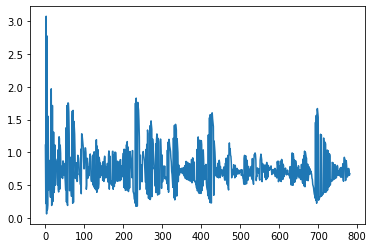

In [13]:
import matplotlib.pyplot as plt
plt.plot([loss_tensor.cpu().detach().numpy() for loss_tensor in loss_vals])

### Load saved model and evaluate

In [14]:
gpu = t.device('cuda') 
model = t.load('./bert-classifier-2-17.pt', gpu)

In [15]:
model_weights = model
pretrained_bert = BertClassifier(**default_config)
pretrained_bert

pretrained_bert.load_state_dict(model_weights)

<All keys matched successfully>

In [16]:
bert_cpu = pretrained_bert.to('cpu')

In [19]:
acc = lambda outputs, targets: sum((outputs > 0.5).squeeze().int() == targets) / len(inputs)

accs = []
for i, data in enumerate(test[0:10]):
    targets, inputs = zip(*data)
    targets = t.Tensor(targets)
    inputs = t.stack(inputs)
    _, outputs = bert_cpu(inputs)
    
    accs.append(acc(outputs, targets))

KeyboardInterrupt: 

In [ ]:
accs